In [1]:
import os
from os import environ
import sys
import io
from os.path import expanduser
sys.path.append("../model/robosat_pink/")

from importlib import import_module
import pkgutil

import boto3
import s3fs

from re import match 

from numpy.random import randint
import numpy as np

import robosat_pink.losses
import robosat_pink.models
from robosat_pink.datasets import MultiSlippyMapTilesConcatenation
from robosat_pink.tools.train import get_dataset_loaders
from robosat_pink.config import load_config
from robosat_pink.logs import Logs

import torch
import torch.backends.cudnn
from torch.optim import Adam
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Experiment with Trained Model
as follows:


In [2]:
trainedModel = "s3://planet-snowcover-models/05-02-19-checkpoints/checkpoint-00010-of-00010.pth"
modelConfig = '../s3-train.toml'

S3_CHECKPOINT = False
if trainedModel.startswith("s3://"):
    S3_CHECKPOINT = True
    # load from s3 
    trainedModel = trainedModel[5:]
    sess = boto3.Session(profile_name='esip')
    fs = s3fs.S3FileSystem(session=sess)
    s3ckpt = s3fs.S3File(fs, trainedModel, 'rb')
    


## Build Network

In [3]:
config = load_config(modelConfig)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")


num_classes = len(config["classes"])
num_channels = 0
for channel in config["channels"]:
    num_channels += len(channel["bands"])
pretrained = config["model"]["pretrained"]
encoder = config["model"]["encoder"]

models = [name for _, name, _ in pkgutil.iter_modules([os.path.dirname(robosat_pink.models.__file__)])]
if config["model"]["name"] not in [model for model in models]:
    sys.exit("Unknown model, thoses available are {}".format([model for model in models]))

model_module = import_module("robosat_pink.models.{}".format(config["model"]["name"]))
net = getattr(model_module, "{}".format(config["model"]["name"].title()))(
    num_classes=num_classes, num_channels=num_channels, encoder=encoder, pretrained=pretrained
).to(device)

net = torch.nn.DataParallel(net)
optimizer = Adam(net.parameters(), lr=config["model"]["lr"], weight_decay=config["model"]["decay"])


## Load Checkpoint

In [4]:

def map_location(storage, _):
    return storage.cuda() if torch.cuda.is_available() else storage.cpu()
try: 
    if S3_CHECKPOINT:
        with s3fs.S3File(fs, trainedModel, 'rb') as C:
            state = torch.load(io.BytesIO(C.read()), map_location = map_location)
    else: 
        state = torch.load(trainedModel, map_location= map_location)
    optimizer.load_state_dict(state['optimizer'])
    net.load_state_dict(state['state_dict'])
    net.to(device)
except FileNotFoundError as f:
    print("{} checkpoint not found.".format(CHECKPOINT))

losses = [name for _, name, _ in pkgutil.iter_modules([os.path.dirname(robosat_pink.losses.__file__)])]
if config["model"]["loss"] not in [loss for loss in losses]:
    sys.exit("Unknown loss, thoses available are {}".format([loss for loss in losses]))

loss_module = import_module("robosat_pink.losses.{}".format(config["model"]["loss"]))
criterion = getattr(loss_module, "{}".format(config["model"]["loss"].title()))().to(device)

In [5]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name = config['dataset']['aws_profile']))

imagery_searchpath = config['dataset']['image_bucket']  + '/' +  config['dataset']['imagery_directory_regex']
print("Searching for imagery...({})".format(imagery_searchpath))
imagery_candidates = fs.ls(config['dataset']['image_bucket'])
print("candidates:")
print(imagery_candidates)
imagery_locs = [c for c in imagery_candidates if match(imagery_searchpath, c)]
print("result:")
print(imagery_locs)

mask_searchpath = config['dataset']['mask_bucket'] + '/' +  config['dataset']['mask_directory_regex']
print("Searching for mask...({})".format(mask_searchpath))
mask_candidates = fs.ls(config['dataset']['mask_bucket'])
print("candidates:")
print(mask_candidates)
mask_locs = [c for c in mask_candidates if match(mask_searchpath, c)]
print("result:")
print(mask_locs)

assert(len(mask_locs) > 0 and len(imagery_locs) > 0)

print("Merging tilesets...")

allTiles = MultiSlippyMapTilesConcatenation(imagery_locs, mask_locs, aws_profile = config['dataset']['aws_profile'])

Searching for imagery...(planet-snowcover-imagery/(.*)_AnalyticMS_SR_clip_tiled)
candidates:
['planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181447_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181448_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_SR_clip_scaled.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181449_0f32_metadata.json', 'plan

## Test

In [34]:
limit = 8
images, masks, tiles = [], [], []
idxs = randint(0, len(allTiles), size=limit)
for i in idxs:
    i, m, t = allTiles[i]
    images.append(i)
    masks.append(m)
    tiles.append(t)

imageTensor = torch.from_numpy(np.stack(images))

In [35]:
masks = np.stack(masks)

In [36]:
net.eval()
with torch.no_grad():
    raw = net(imageTensor)

In [50]:
def plot3(image, mask, pred, tile, ax = None):
#     fig.suptitle(tile)
    ax[0].imshow(image)
    ax[0].set_title(tile)
    ax[1].imshow(mask)
    ax[1].set_title("mask")
    ax[2].imshow(pred, cmap='cividis', vmin = 0, vmax = 1)
    ax[2].set_title('prediction')
    diff = ax[3].imshow((pred > 0) - mask, cmap='seismic')
    mets = sklearn.metrics.precision_recall_fscore_support(np.round(mask.flatten()), 
                                                          (pred > 0).flatten().astype(int), average='binary')
#    ax[3].set_title(mets)
#     plt.colorbar(diff, ax = ax[3])
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


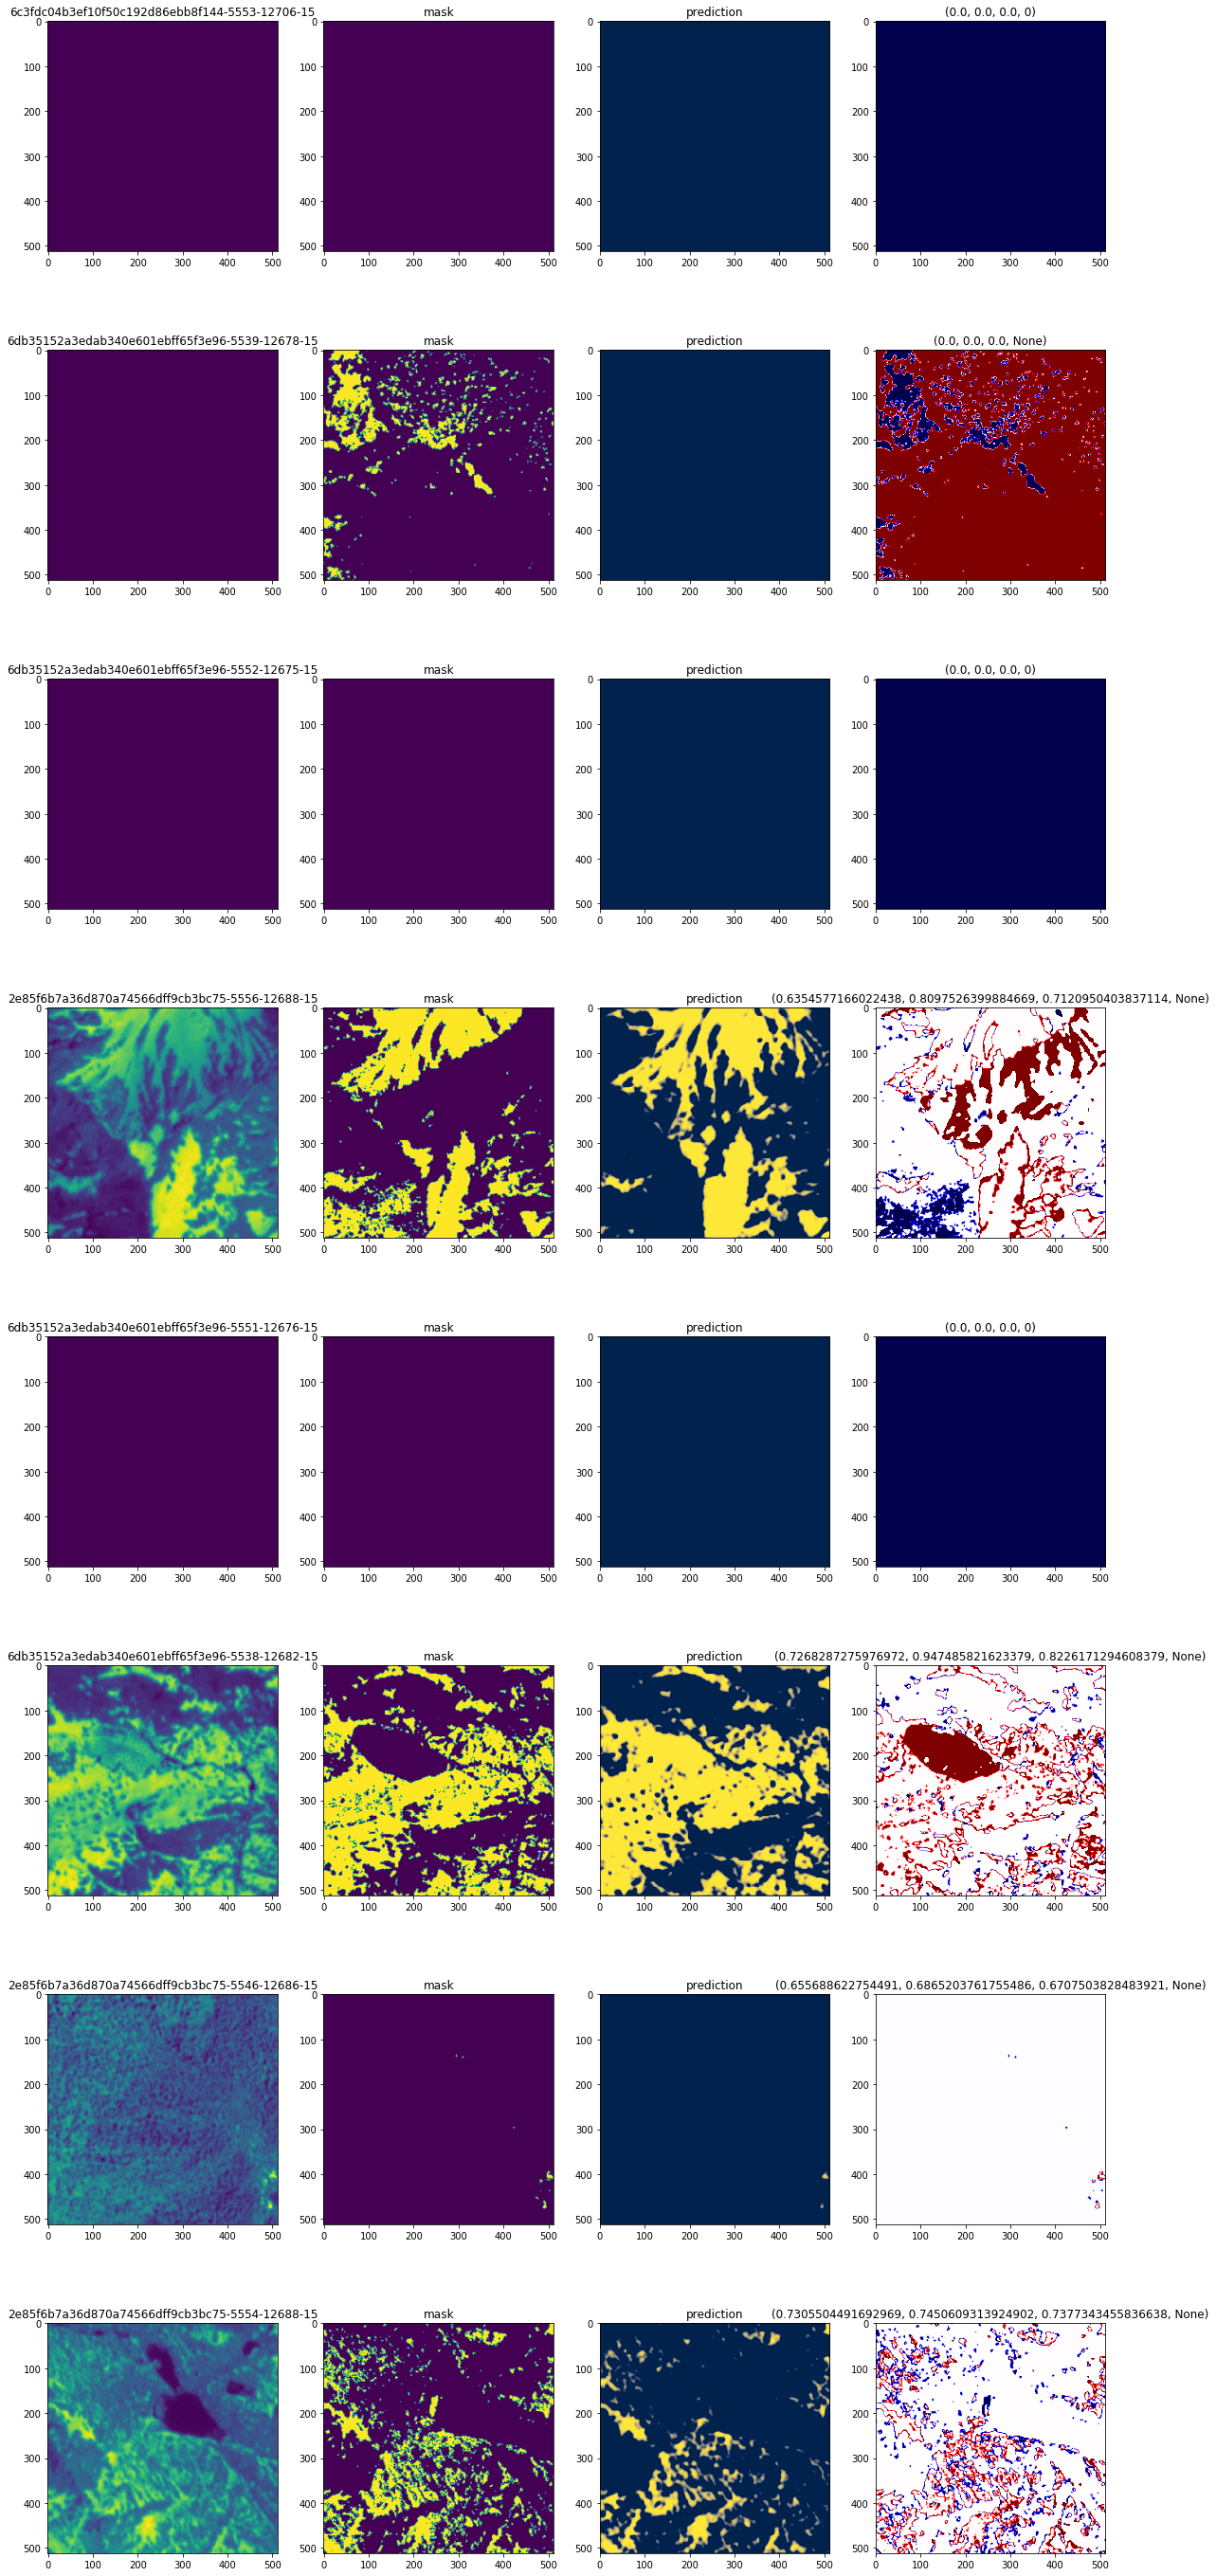

In [38]:
fig, ax = plt.subplots(raw.shape[0], 4, figsize=(20, 50))
for image in range(raw.shape[0]):
    plot3(imageTensor[image, 3, :, :], masks[image, :, :],  (raw[image]).detach().numpy().squeeze()  , tiles[image], ax = ax[image])
#    plot3(s[0][image, 3, :, :], s[1][image, :, :],  torch.nn.functional.softmax(raw[image].squeeze(), dim=0).data.cpu().numpy())

plt.savefig("testout.png")

---

In [11]:
import sklearn

In [12]:
from sklearn.metrics import roc_curve, auc


In [19]:
print(sklearn.metrics.precision_recall_fscore_support(np.round(masks.flatten()), (raw > 0).flatten().numpy(), average='binary'))

(0.7723510743272676, 0.7569613856555377, 0.7645787956790532, None)


In [14]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(np.round(masks.flatten()), (raw > 0).flatten().numpy())
roc_auc = sklearn.metrics.auc(fpr, tpr)
print("\n Area under the ROC curve : %f" % roc_auc)


 Area under the ROC curve : 0.872022


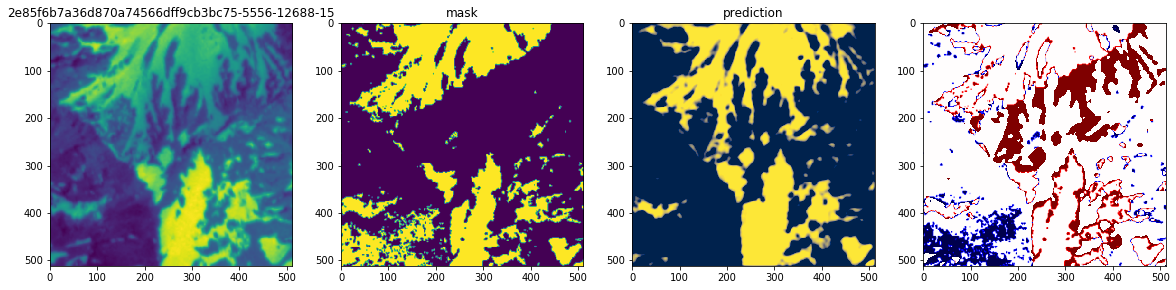

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
plot3(imageTensor[3, 3, :, :], masks[3, :, :],  (raw[3]).detach().numpy().squeeze()  , tiles[3], ax = ax)
                       
plt.savefig("../artifacts/figures/lowelev.png", bbox_inches='tight', dpi=300)
